<a href="https://colab.research.google.com/github/shelly-serafimovich/ML-Moral-Judgment-and-Liability-Project/blob/main/ML_Moral_Judgment_and_Liability_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## all data

Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Metric calculation

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def calc_metrics(y_test, y_pred):
  # Calculating accuracy and other metrics
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred)

  # Output results
  print("Accuracy:", accuracy)
  print("Classification Report:\n", report)

  # Calculate precision, recall, and F1 score
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)

  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1 Score: {f1:.4f}')

  # Plotting the confusion matrix with percentages
  cm = confusion_matrix(y_test, y_pred)
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix
  sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap='Blues')
  plt.title('Confusion Matrix (Normalized)')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

Text preprocessing

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        nltk.download('stopwords')
        self.stop_words = set(stopwords.words('english'))
        nltk.download('punkt')
        nltk.download('wordnet')
        self.lemmatizer = WordNetLemmatizer()

    def tokenize_text(self, text):
        word_tokens = word_tokenize(text)
        filtered_text = [word for word in word_tokens if word.lower() not in self.stop_words]
        return filtered_text

    def lemmatize_text(self, tokens):
        return ' '.join([self.lemmatizer.lemmatize(w) for w in tokens])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.Series):
            processed_data = X.apply(self.tokenize_text)
            lemmatized_output = processed_data.apply(self.lemmatize_text)
        else:
            processed_data = [self.tokenize_text(text) for text in X]
            lemmatized_output = [self.lemmatize_text(tokens) for tokens in processed_data]
        return lemmatized_output


Model pipline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.5502097902097902
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.57      0.57      1900
           1       0.52      0.53      0.53      1675

    accuracy                           0.55      3575
   macro avg       0.55      0.55      0.55      3575
weighted avg       0.55      0.55      0.55      3575

Precision: 0.5195
Recall: 0.5319
F1 Score: 0.5257


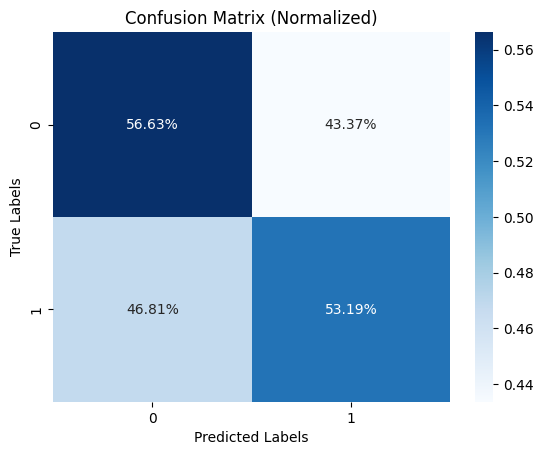

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import joblib

# Loading the datasets
moral_df = pd.read_csv('/content/Merged_Dataset.csv')

X_lem = moral_df['text']  # Assuming 'text' is the column with text data
y_lem = moral_df['label']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=20)

# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('log_reg', LogisticRegression(penalty='l2', class_weight='balanced', random_state=20, C=10))
])

# Training the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)
calc_metrics(y_test, y_pred)

predictions

In [ ]:
# Function to predict new text
def predict_text(text):
    prediction = pipeline.predict([text])
    if hasattr(pipeline.named_steps['log_reg'], 'predict_proba'):
        probability = pipeline.predict_proba([text])[:, 1]  # Probability of the positive class
        return prediction[0], probability[0]
    else:
        return prediction[0], None

# Example usage of the function
new_text = "I just got pregnant in school, I want to make an abortion."
predicted_label, predicted_probability = predict_text(new_text)
print(f"Predicted Label: {predicted_label}, Probability: {predicted_probability:.2%}" if predicted_probability is not None else f"Predicted Label: {predicted_label}")

Predicted Label: 0, Probability: 39.28%


detrmine threshold

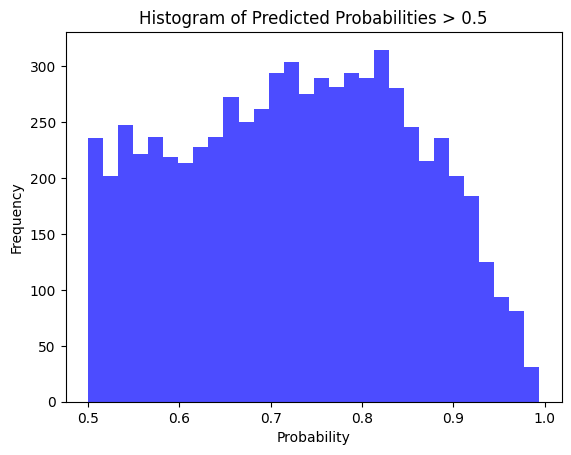

Threshold where the lowest 10% of probabilities fall below is: 0.5495227908646486


In [ ]:
# Get probabilities for the positive class
probabilities = pipeline.predict_proba(X_train)[:, 1]

# Filter probabilities greater than 0.5
filtered_probabilities = probabilities[probabilities > 0.5]

# Plot histogram of filtered probabilities
plt.hist(filtered_probabilities, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Predicted Probabilities > 0.5')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

# Calculate the 10th percentile (threshold)
threshold = np.percentile(filtered_probabilities, 10)
print(f"Threshold where the lowest 10% of probabilities fall below is: {threshold}")

The lower decile was found to be 54.95 percent. Based on the company's policy and budget constraints, we will establish a threshold below this percentage level of confidence to prompt intervention from a specialist doctor in the decision-making process.

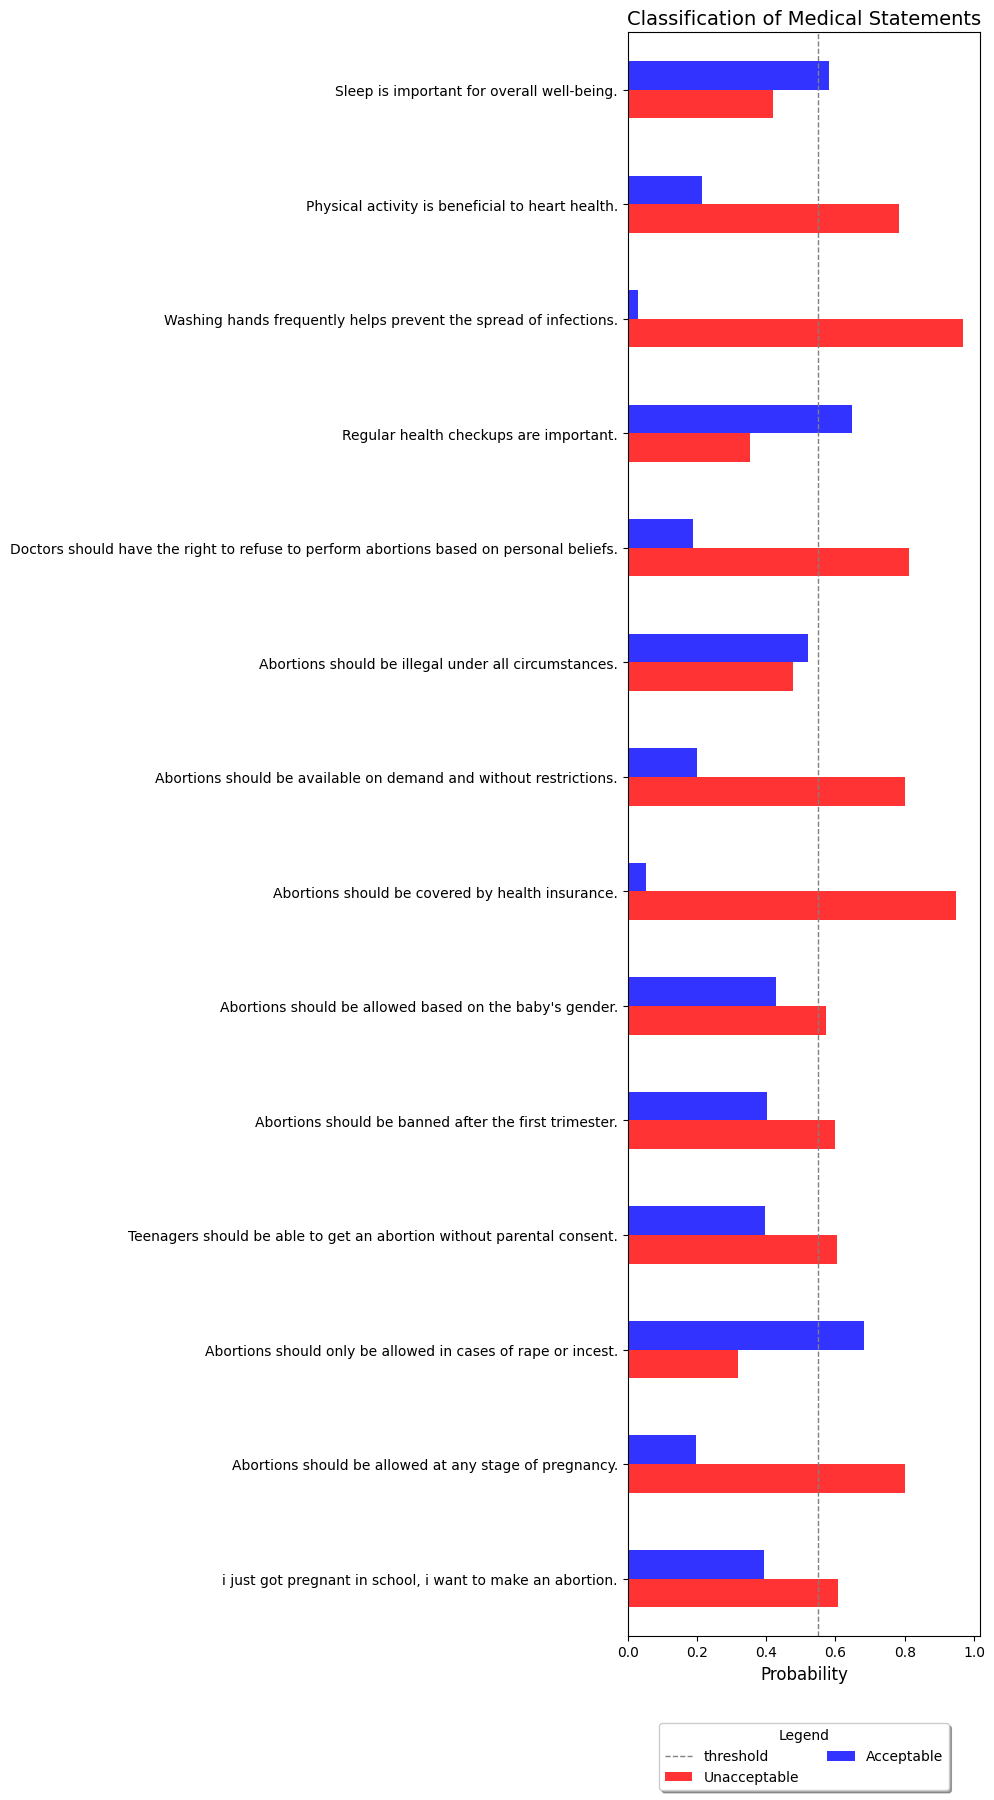

In [ ]:
# Function to predict text probabilities
def predict_text_probabilities(texts):
    # The input 'texts' is a list of text strings
    probabilities = pipeline.predict_proba(texts)
    return probabilities

# List of controversial and less controversial medical statements
controversial_texts = [
    "i just got pregnant in school, i want to make an abortion.",
    "Abortions should be allowed at any stage of pregnancy.",
    "Abortions should only be allowed in cases of rape or incest.",
    "Teenagers should be able to get an abortion without parental consent.",
    "Abortions should be banned after the first trimester.",
    "Abortions should be allowed based on the baby's gender.",
    "Abortions should be covered by health insurance.",
    "Abortions should be available on demand and without restrictions.",
    "Abortions should be illegal under all circumstances.",
    "Doctors should have the right to refuse to perform abortions based on personal beliefs."
]

less_controversial_texts = [
    "Regular health checkups are important.",
    "Washing hands frequently helps prevent the spread of infections.",
    "Physical activity is beneficial to heart health.",
    "Sleep is important for overall well-being."
]

# Combine both lists for processing
texts = controversial_texts + less_controversial_texts

# Get predictions
probabilities = pipeline.predict_proba(texts)

# Create a DataFrame from the predictions
df_predictions = pd.DataFrame(probabilities, columns=['Acceptable', 'Unacceptable'], index=texts)

# Color assignment for each group
colors = ['#FF3333', '#3333FF'] * len(controversial_texts) + ['#33CCFF', '#FFA500'] * len(less_controversial_texts)

# Plotting
fig, ax = plt.subplots(figsize=(10, 18))  # Adjust figure size to accommodate all entries
df_predictions.plot(kind='barh', ax=ax, color=colors, fontsize=10)
ax.set_xlabel('Probability', fontsize=12)
ax.set_title('Classification of Medical Statements', fontsize=14)
plt.axvline(x=0.5495227908646486, color='gray', linestyle='--', linewidth=1)
plt.legend(['threshold', 'Unacceptable', 'Acceptable'],
           title='Legend', loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.show()

# data analysis

all data

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

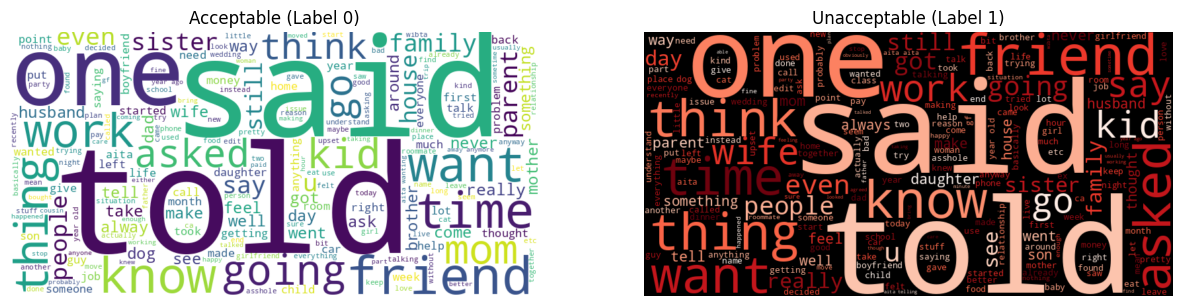

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Setup stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())  # Convert to lower case
    # Remove stopwords and non-alphabetic tokens, and lemmatize
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(lemmatized)


# Filter texts by label
acceptable_texts = moral_df[moral_df['label'] == 0]['text']
unacceptable_texts = moral_df[moral_df['label'] == 1]['text']

# Apply text preprocessing
acceptable_combined = " ".join([preprocess_text(text) for text in acceptable_texts])
unacceptable_combined = " ".join([preprocess_text(text) for text in unacceptable_texts])

# Create WordCloud objects
wordcloud_acceptable = WordCloud(width=800, height=400, background_color='white').generate(acceptable_combined)
wordcloud_unacceptable = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(unacceptable_combined)

# Display the generated Word Clouds
plt.figure(figsize=(15, 7))

# Word Cloud for acceptable texts
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(wordcloud_acceptable, interpolation='bilinear')
plt.title('Acceptable (Label 0)')
plt.axis("off")

# Word Cloud for unacceptable texts
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(wordcloud_unacceptable, interpolation='bilinear')
plt.title('Unacceptable (Label 1)')
plt.axis("off")

plt.show()

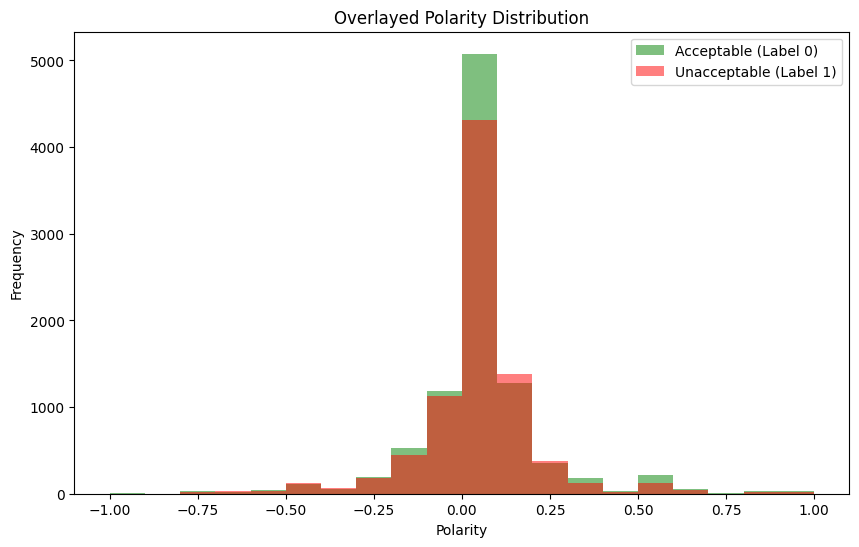

In [ ]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt


# Function to compute polarity
def compute_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to compute polarity
moral_df['polarity'] = moral_df['text'].apply(compute_polarity)

# Filter polarity scores by label
acceptable_polarity = moral_df[moral_df['label'] == 0]['polarity']
unacceptable_polarity = moral_df[moral_df['label'] == 1]['polarity']

# Plotting the distribution of polarity scores
plt.figure(figsize=(10, 6))

# Overlay histograms
plt.hist(acceptable_polarity, bins=20, color='green', alpha=0.5, label='Acceptable (Label 0)')
plt.hist(unacceptable_polarity, bins=20, color='red', alpha=0.5, label='Unacceptable (Label 1)')

plt.title('Overlayed Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

In [20]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = spacy.load("en_core_web_sm")
texts = moral_df['text']

# Function to extract entities, excluding PERSON and numbers
def extract_entities(sentences):
    entity_pairs = []
    for sentence in sentences:
        doc = nlp(sentence)
        # Exclude PERSON and numerical data
        entities = [ent.text for ent in doc.ents if ent.label_ not in {'PERSON', 'DATE', 'TIME', 'QUANTITY', 'ORDINAL', 'CARDINAL'}]
        # Generate pairs of entities
        for i in range(len(entities)):
            for j in range(i + 1, len(entities)):
                entity_pairs.append((entities[i], entities[j]))
    return entity_pairs

# Extract entities and generate pairs
entity_pairs = extract_entities(texts)

# Create a graph
G = nx.Graph()

# Add edges to the graph
for source, target in entity_pairs:
    if G.has_edge(source, target):
        G[source][target]['weight'] += 1
    else:
        G.add_edge(source, target, weight=1)

# Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5)  # Adjust layout

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=2500)

# Draw edges with weights affecting thickness
weights = [edata['weight'] for _, _, edata in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=[w * 0.5 for w in weights])  # Adjust width factor as needed

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10)

plt.title('Network of Co-occurring Medical Entities')
plt.axis('off')  # Turn off the axis
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 146 (\x92) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 147 (\x93) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 148 (\x94) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: 
a little more $$
              ^
ParseException: Expected end of text, found '$'  (at char 14), (line:1, col:15)

<Figure size 1000x800 with 1 Axes>

# function for streamlit

In [ ]:
import joblib

# Function to save the model to a file
def save_model(model, filename):
    joblib.dump(model, filename)

# Function to load the model from a file
def load_model(filename):
    return joblib.load(filename)

# Save the model
model_filename = 'trained_model.joblib'
save_model(pipeline, model_filename)

# Function to evaluate text with loaded model
def evaluate_text(model_filename, text):
    model = load_model(model_filename)
    probabilities = model.predict_proba([text])[0]
    if probabilities[0] > 0.60:
        return 0  # Class 0 probability > 60%
    elif probabilities[1] > 0.60:
        return 1  # Class 1 probability > 60%
    else:
        return 2  # No probability exceeds 60%

# Example usage
example_text = "Abortions should be illegal under all circumstances."
result = evaluate_text(model_filename, example_text)
print(f"Result for the provided text: {result}")

Result for the provided text: 2


# Legal data creation

In [ ]:
import pandas as pd
import numpy as np

# Define conditions and templates
conditions = [
    "age_condition", "rape_condition", "health_condition", "unmarried_condition", "disability_condition"
]
templates = {
    "age_condition": "I am a {}-year-old woman from Israel and I wish to have an abortion. I am {}.",
    "rape_condition": "I am a {}-year-old woman from Israel and I wish to have an abortion because the pregnancy is a result of rape. I am {}.",
    "health_condition": "I am a {}-year-old woman from Israel and I wish to have an abortion because the pregnancy may endanger my life. I am {}.",
    "unmarried_condition": "I am a {}-year-old unmarried woman from Israel and I wish to have an abortion. I am {}.",
    "disability_condition": "I am a {}-year-old woman from Israel and I wish to have an abortion because the child may have a physical disability. I am {}.",
    "no_condition_1": "I am a {}-year-old woman from Israel, married, pregnant with my husband, and currently the pregnancy is not suitable for me because we already have 3 children. I want to have an abortion. I am {}.",
    "no_condition_2": "I am a {}-year-old woman from Israel, married, and financially stable, but I want to have an abortion because I do not want children right now. I am {}.",
    "no_condition_3": "I am a {}-year-old woman from Israel, in good health, and this pregnancy is not convenient for my career right now. I want to have an abortion. I am {}."
}

# Age ranges for conditions
ages = {
    "age_condition": list(range(12, 19)) + list(range(40, 61)),
    "rape_condition": range(19, 40),
    "health_condition": range(19, 40),
    "unmarried_condition": range(19, 40),
    "disability_condition": range(19, 40),
    "no_condition": range(19, 40)
}

# Cultural backgrounds (subset specific to Israel)
cultures = ["Jewish", "Arab", "Druze", "Christian", "Bedouin"]

# Socioeconomic status options
socioeconomic_statuses = ["low", "medium", "high"]

# Gender definitions
gender_definitions = ["lesbian", "bi", "straight", "trans"]

# Generate sentences
np.random.seed(42)
data = []

for _ in range(125):  # 125 examples per template to reach 1000
    for condition, template in templates.items():
        if "no_condition" in condition:
            age = np.random.choice(list(ages["no_condition"]))
        else:
            age = np.random.choice(list(ages[condition]))
        culture = np.random.choice(cultures)
        socioeconomic_status = np.random.choice(socioeconomic_statuses)
        gender_definition = np.random.choice(gender_definitions)
        sentence = template.format(age, culture, gender_definition)

        # Determine which conditions are met
        age_condition = age < 19 or age >= 40
        rape_condition = "rape" in template
        health_condition = "endanger my life" in template
        unmarried_condition = "unmarried" in template
        disability_condition = "physical disability" in template

        # Binary label: 0 if any condition is met, 1 if none
        meets_condition = age_condition or rape_condition or health_condition or unmarried_condition or disability_condition
        label = 0 if meets_condition else 1

        data.append((sentence, age_condition, rape_condition, health_condition, unmarried_condition, disability_condition, culture, socioeconomic_status, gender_definition, label))

# Create DataFrame
df = pd.DataFrame(data, columns=["Sentence", "age_condition", "rape_condition", "health_condition", "unmarried_condition", "disability_condition", "culture", "socioeconomic_status", "gender_definition", "label"])

# Save to CSV
df.to_csv("compliance_test_set_tagged.csv", index=False)


                                            Sentence  age_condition  \
0  I am a 18-year-old woman from Israel and I wis...           True   
1  I am a 29-year-old woman from Israel and I wis...          False   
2  I am a 37-year-old woman from Israel and I wis...          False   
3  I am a 39-year-old unmarried woman from Israel...          False   
4  I am a 39-year-old woman from Israel and I wis...          False   

   rape_condition  health_condition  unmarried_condition  \
0           False             False                False   
1            True             False                False   
2           False              True                False   
3           False             False                 True   
4           False             False                False   

   disability_condition    culture socioeconomic_status gender_definition  \
0                 False  Christian                  low          straight   
1                 False    Bedouin                  low   

In [6]:
df = pd.read_csv('/content/compliance_test_set_tagged (2).csv')
# Predict the label
df['predicted_label'] = pipeline.predict(df['Sentence'])

# Predict the probabilities and take the maximum probability for each prediction
df['prediction_probability'] = pipeline.predict_proba(df['Sentence']).max(axis=1)
output_path = '/content/compliance_test_set_tagged_model.csv'
df.to_csv(output_path, index=False)

# Audit - test and analysis

## analysis

### cultures

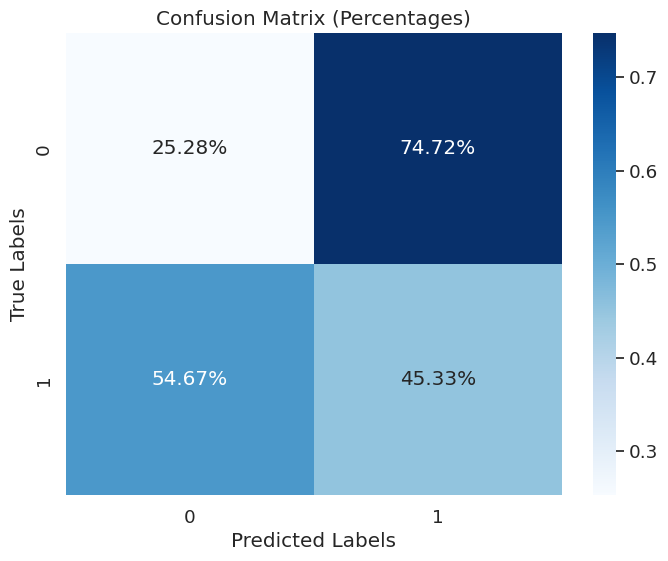

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


df = pd.read_csv("/content/compliance_test_set_tagged_model.csv")

# Extract the true labels and predicted labels
y_true = df["label"]
y_pred = df["predicted_label"]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix by dividing by the total number of instances
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Percentages)")
plt.show()


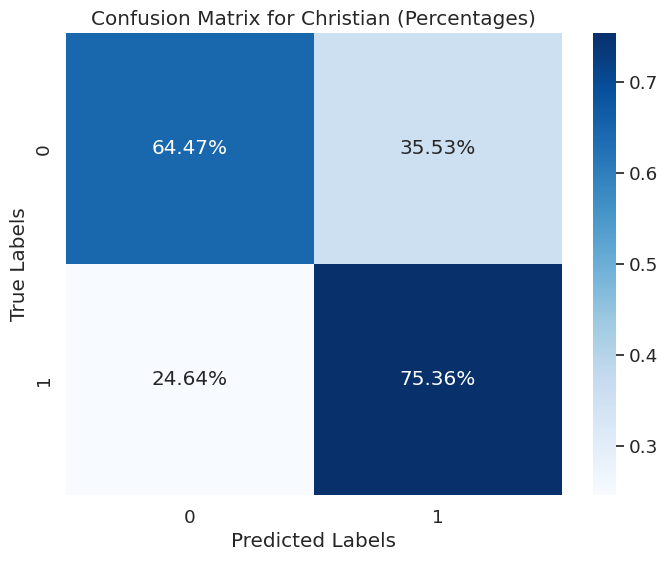

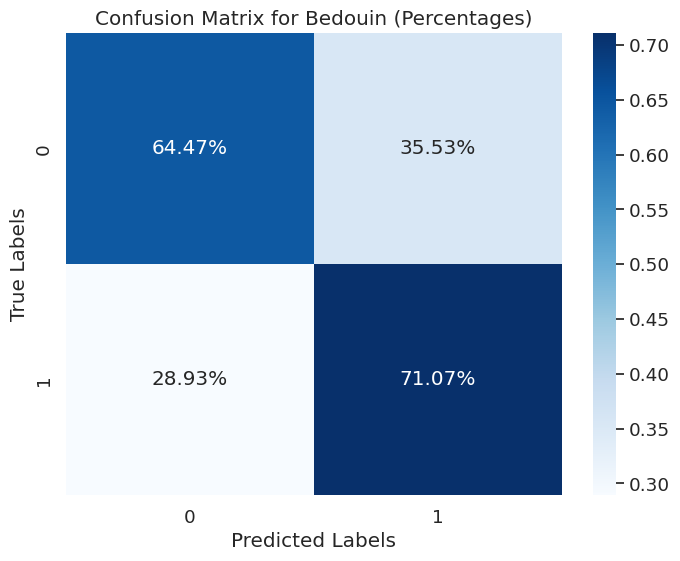

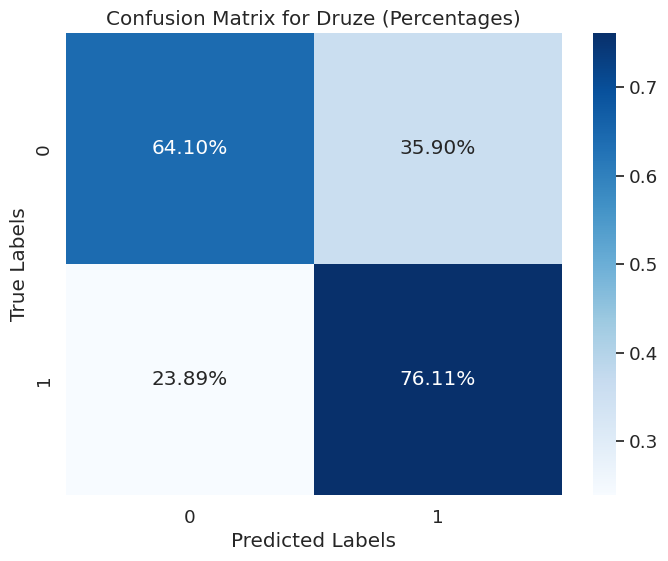

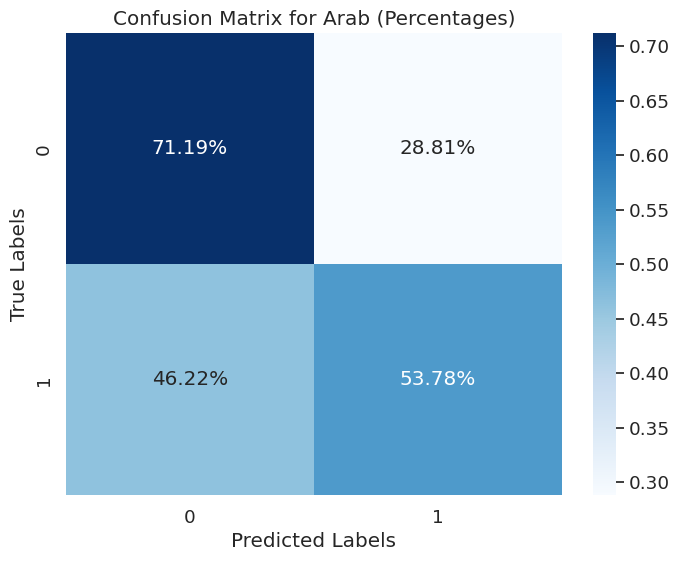

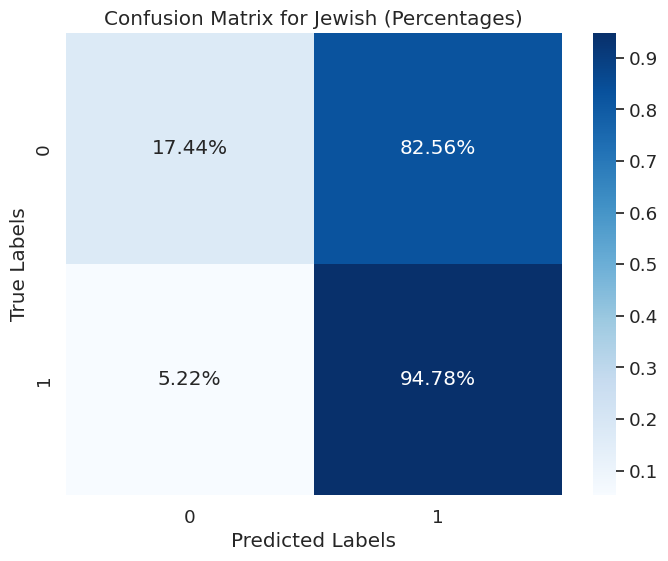

In [9]:
# Define a function to plot confusion matrix for a given culture
def plot_confusion_matrix_for_culture(df, culture):
    # Filter the DataFrame for the specific culture
    df_culture = df[df["culture"] == culture]

    # Extract the true labels and predicted labels
    y_true = abs(df_culture["label"] - 1)
    y_pred = df_culture["predicted_label"]

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix by dividing by the total number of instances
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {culture} (Percentages)")
    plt.show()

# Get the unique cultures
cultures = df["culture"].unique()

# Plot confusion matrix for each culture
for culture in cultures:
    plot_confusion_matrix_for_culture(df, culture)

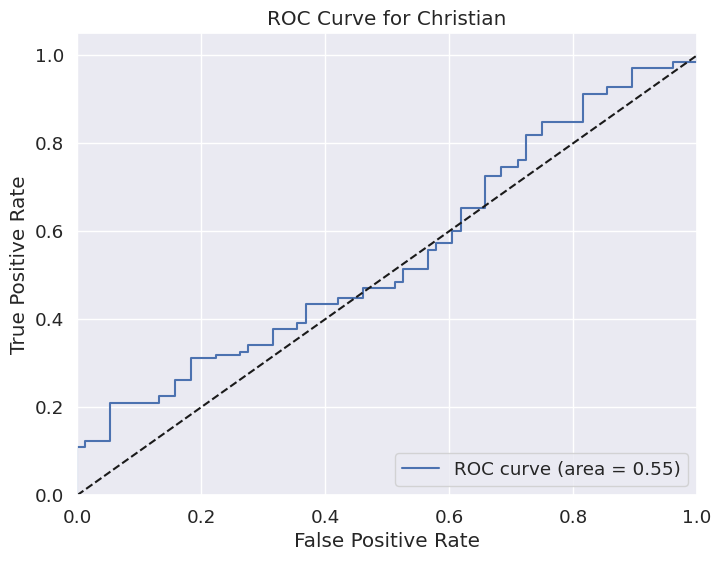

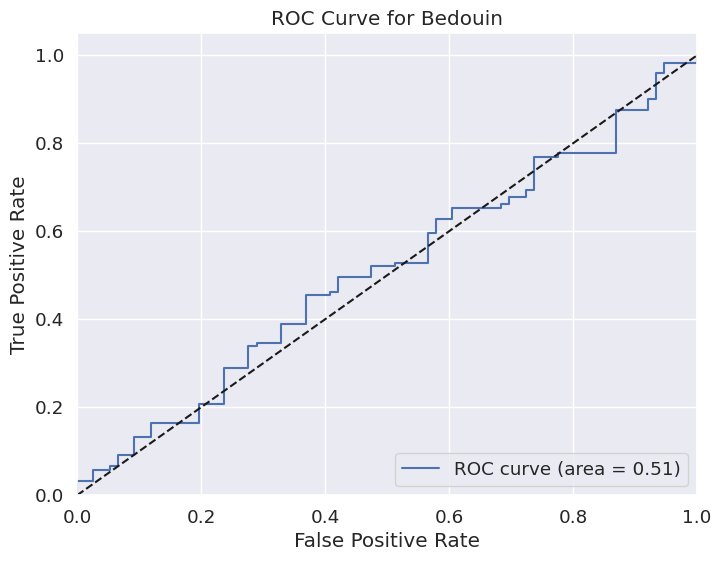

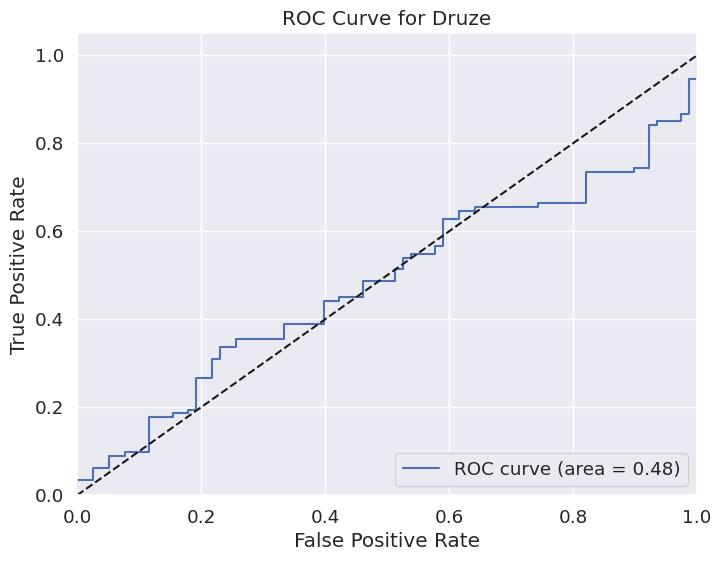

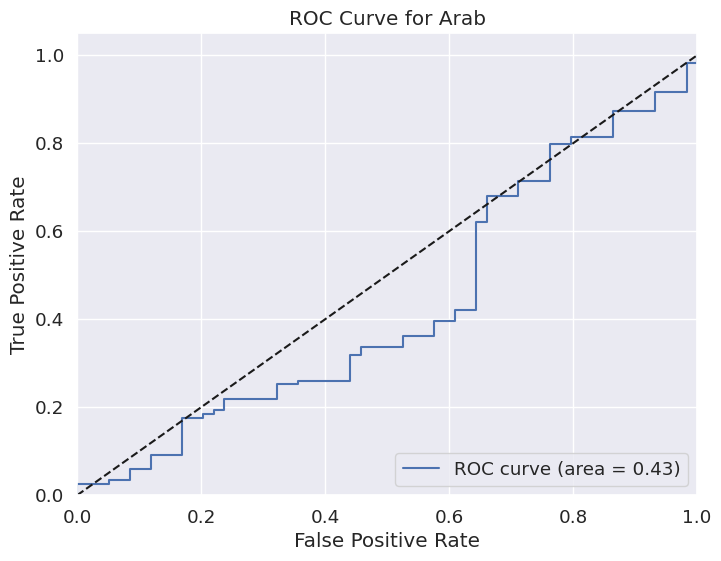

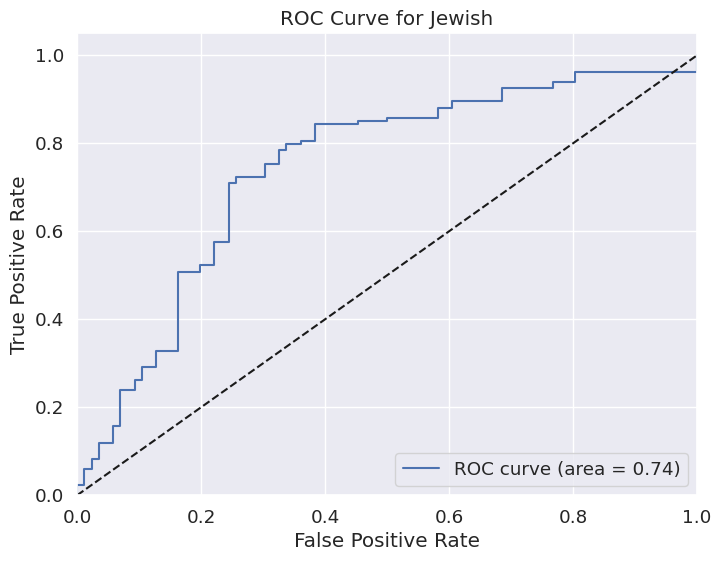

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

cultures = df["culture"].unique()

def plot_roc_curve_for_religion(df, culture):
    df_culture = df[df["culture"] == culture]
    y_true = abs(df_culture["label"] - 1)
    y_score = df_culture["prediction_probability"]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {culture}')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve for each religion
for culture in cultures:
    plot_roc_curve_for_religion(df, culture)


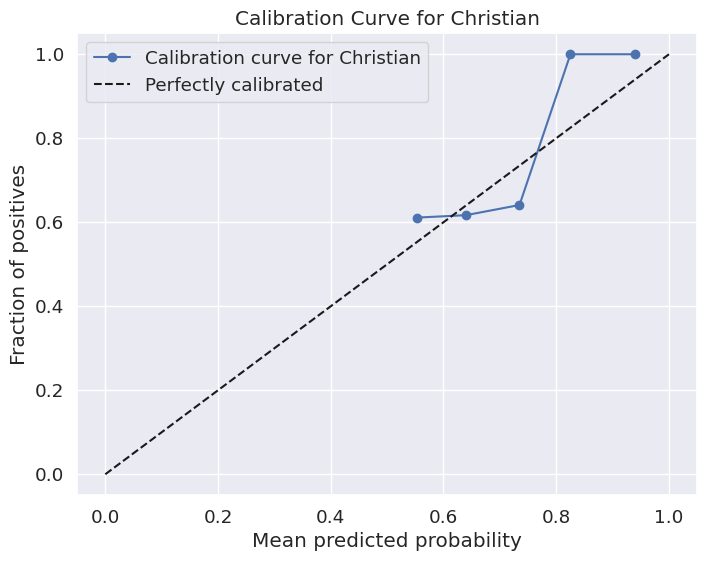

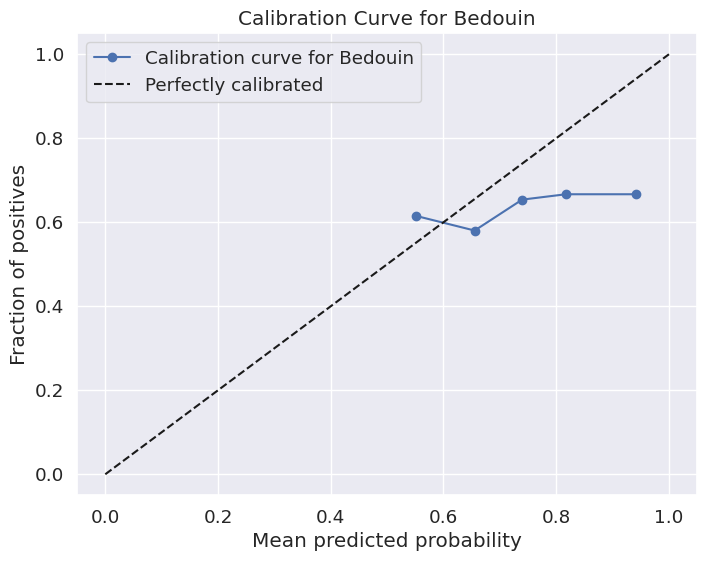

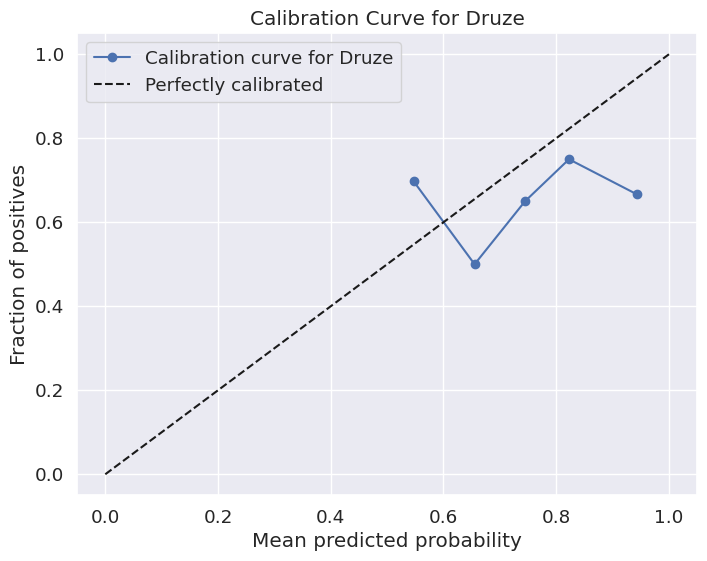

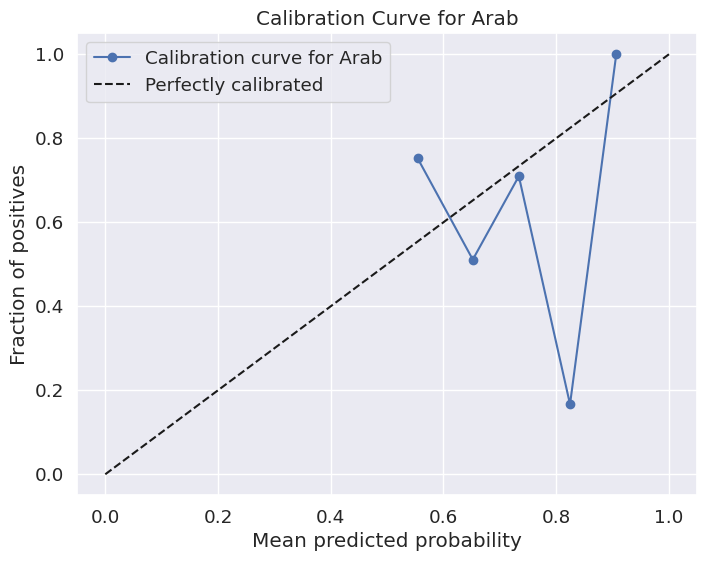

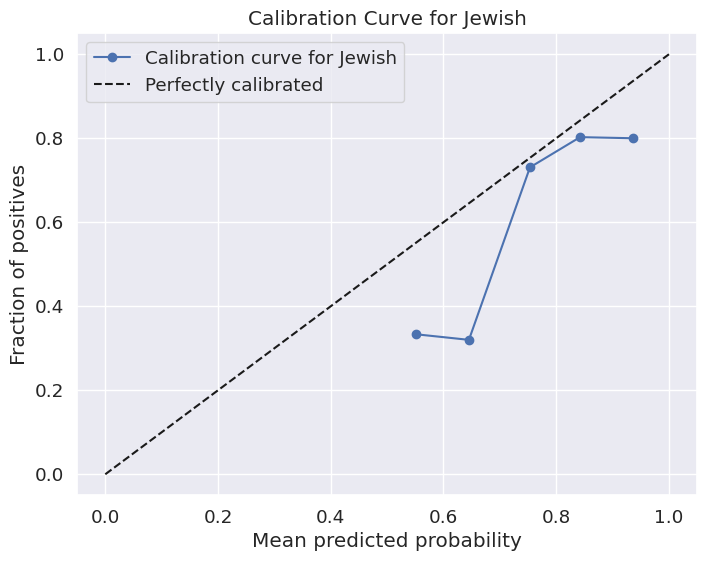

In [16]:
from sklearn.calibration import calibration_curve

# Define a function to plot calibration curve for each culture
def plot_calibration_curve_for_culture(df, culture):
    df_culture = df[df["culture"] == culture]
    y_true = abs(df_culture["label"] - 1)
    y_prob = df_culture["prediction_probability"]

    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)

    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label=f'Calibration curve for {culture}')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration Curve for {culture}')
    plt.legend(loc="upper left")
    plt.show()

# Get the unique cultures
cultures = df["culture"].unique()

# Plot calibration curve for each culture
for culture in cultures:
    plot_calibration_curve_for_culture(df, culture)

In [18]:
# Function to calculate statistical parity difference for each religion
def statistical_parity_difference(df, culture):
    df_culture = df[df["culture"] == culture]
    selection_rate = df_culture["predicted_label"].mean()
    overall_rate = df["predicted_label"].mean()
    parity_difference = selection_rate - overall_rate
    print(f"Statistical Parity Difference for {culture}: {parity_difference:.2f}")

# Calculate statistical parity difference for each religion
for culture in cultures:
    statistical_parity_difference(df, culture)

Statistical Parity Difference for Christian: -0.02
Statistical Parity Difference for Bedouin: -0.06
Statistical Parity Difference for Druze: -0.04
Statistical Parity Difference for Arab: -0.18
Statistical Parity Difference for Jewish: 0.26


Statistical Parity Difference (SPD) Summary:


*   **Christian: -0.02**<br>
Interpretation: The Christian group has a selection rate 2% lower than the overall population. This means Christians are slightly less likely to be given permission to perform an abortion compared to the general population.

*  **Bedouin: -0.06**<br>
Interpretation: The Bedouin group has a selection rate 6% lower than the overall population. This indicates Bedouins are somewhat less likely to be given permission to perform an abortion compared to the general population.


*   **Druze: -0.04**<br>
Interpretation: The Druze group has a selection rate 4% lower than the overall population. This indicates Druze individuals are slightly less likely to be given permission to perform an abortion compared to the general population.

*  **Arab: -0.18**<br>
Interpretation: The Arab group has a selection rate 18% lower than the overall population. This indicates Arabs are significantly less likely to be given permission to perform an abortion compared to the general population.

*  **Jewish: 0.26<**br>
Interpretation: The Jewish group has a selection rate 26% higher than the overall population. This means Jews are significantly more likely to be given permission to perform an abortion compared to the general population.










In [19]:
# Function to calculate disparate impact ratio for each culture
def disparate_impact_ratio(df, culture):
    df_culture = df[df["culture"] == culture]
    selection_rate = df_culture["predicted_label"].mean()
    overall_rate = df["predicted_label"].mean()
    disparate_impact = selection_rate / overall_rate
    print(f"Disparate Impact Ratio for {culture}: {disparate_impact:.2f}")

# Get the unique cultures
cultures = df["culture"].unique()

# Calculate disparate impact ratio for each culture
for culture in cultures:
    disparate_impact_ratio(df, culture)

Disparate Impact Ratio for Christian: 0.96
Disparate Impact Ratio for Bedouin: 0.90
Disparate Impact Ratio for Druze: 0.94
Disparate Impact Ratio for Arab: 0.71
Disparate Impact Ratio for Jewish: 1.41


Results Interpretation:


*   Christian: 0.96<br>
Interpretation: The selection rate for the Christian group is 96% of the overall population's selection rate. This indicates minimal bias against Christians, as the model's predictions for this group are quite aligned with the general population.

*   Bedouin: 0.90<br>
Interpretation: The selection rate for the Bedouin group is 90% of the overall population's selection rate. This suggests a slight under-selection bias against Bedouins, meaning they are somewhat less likely to be denied permission for an abortion compared to the general population.

*   Druze: 0.94<br>
Interpretation: The selection rate for the Druze group is 94% of the overall population's selection rate. This indicates a slight under-selection bias against Druze individuals.

*   Arab: 0.71<br>
Interpretation: The selection rate for the Arab group is 71% of the overall population's selection rate. This indicates a significant under-selection bias against Arabs, meaning they are substantially less likely to be denied permission for an abortion compared to the general population.


*   Jewish: 1.41<br>
Interpretation: The selection rate for the Jewish group is 141% of the overall population's selection rate. This indicates a significant over-selection bias in favor of Jews, meaning they are substantially more likely to be denied permission for an abortion compared to the general population.









### gender_definition

### socioeconomic_status